In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit
##
from util import tools

In [2]:
plt.rcParams['figure.figsize'] = (16, 4.5)
plt.style.use('seaborn-whitegrid')

In [3]:
path = './util/datastore/yield_italy_daily_2010_2020.xlsx'
data = tools.load_BTP_curve(path)
data = data
diff_r = data.diff()[1:]

In [4]:
tenors = np.array(data.columns.values)

In [5]:
data.columns.values

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 15, 20, 30], dtype=int64)

In [6]:
sigma = diff_r.cov()
sigma *= 252 # annualized
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (12, 12)


### Volatility Fitting
The eigenvectors of the Covariance matrix are actually the directions of the axes where there is the most variance(most information) and that we call Principal Components. And eigenvalues are simply the coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component.


#### PCA and Eigendecomposition
<ul>
<li>Obtain the Eigenvectors and Eigenvalues from the covariance matrix $\Sigma^{d\times d}$ </li>
<li>Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the k largest eigenvalues where $k$ is the number of dimensions of the new feature subspace $(k≤d)$.</li>
<li>Construct the projection matrix $\pmb{W}^{dxk}$ from the selected $k$ eigenvectors.</li>
<li> Transform the original dataset $\pmb{X}$ via $\pmb{W}$ to obtain a k-dimensional feature subspace Y.

</ul>

In [7]:
eigval, eigvec = np.linalg.eig(sigma)
factors = 3

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigval[i]), eigvec[:,i]) for i in range(len(eigval))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print('Eigenvalues in descending order:')
for i in eig_pairs[:5]:
    print(i[0])

Eigenvalues in descending order:
0.002065832029113486
0.0001320181991700513
2.8182781875024407e-05
1.2136380106650938e-05
9.53767974856639e-06


In [9]:
print("Highest Eigenvalues:")
print(eigval[:3])

Highest Eigenvalues:
[2.06583203e-03 1.32018199e-04 2.81827819e-05]


In [10]:
tot = sum(eigval) # la somma degli autovettori è la varianza totale
var_exp = [(i / tot)*100 for i in sorted(eigval, reverse=True)]
cum_var_explained = np.cumsum(var_exp)

In [11]:
print("Variance% explained by the first 3 Eigenvectors:")
print(cum_var_explained[3])

Variance% explained by the first 3 Eigenvectors:
98.3959560650878


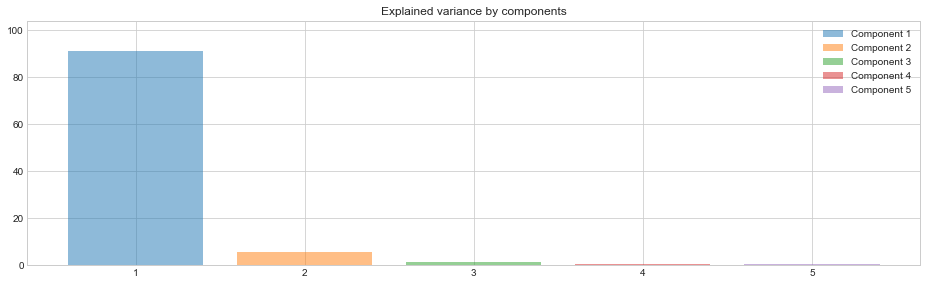

In [12]:
[plt.bar(i +1, var_exp[i], alpha = 0.5, label = ("Component " + str(i +1))) for i in range(0,5)]
[plt.step(i+1, cum_var_explained[i]) for i in range(0,5)]
plt.title("Explained variance by components")
plt.legend()
plt.show()

 Construction of the projection matrix that will be used to transform the original data onto the new feature subspace. Reducing the d-dimensional tenor space to a k-dimensional tenor subspace, by choosing the top $k$ eigenvectors with the highest eigenvalues to construct our $d×k$ dimensional eigenvector matrix $\pmb{W}^{d \times k}$.

$$\pmb{Y}^{n \times k} = \pmb{X}^{n \times d} \times \pmb{W}^{d \times k}$$

Where $d$ is the BTP maturity, $n$ is the observation date and $k$ the number of principal components

In [13]:
nfactors = 3
princ_eigvector = [eig_pairs[i][1] for i in range(0,nfactors)]
princ_eigvalues = [eig_pairs[i][0] for i in range(0,nfactors)]
W_matrix = np.vstack(princ_eigvector).T 

In [14]:
princ_eigvector

[array([0.35210217, 0.35557606, 0.34234954, 0.33046268, 0.31305076,
        0.29306555, 0.27987226, 0.26913176, 0.25713252, 0.22194083,
        0.20195024, 0.17992662]),
 array([-0.53061116, -0.38434209, -0.21826776, -0.09583046,  0.01861948,
         0.12129082,  0.1823776 ,  0.25630172,  0.27421923,  0.31661498,
         0.32656678,  0.34323645]),
 array([ 0.40747538,  0.17220212, -0.12599637, -0.26267735, -0.27834141,
        -0.27069872, -0.19850175, -0.19674856, -0.10843489,  0.24822251,
         0.41773845,  0.49263895])]

In [15]:
Y = data.dot(W_matrix)

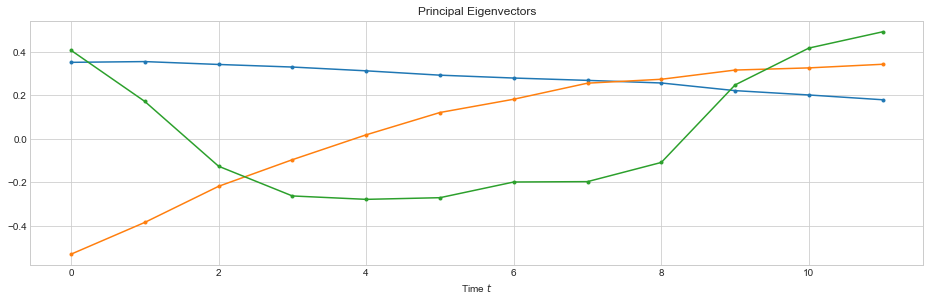

In [16]:
plt.plot(W_matrix, marker='.'), plt.title('Principal Eigenvectors'), plt.xlabel(r'Time $t$');

**Get volatility:** <br>
What is the norm that was used to scale the eigenvector? It is the square root of the sum of squares of the coefficicents in the vector, i.e. the square root of the variance. The eigenvalue is the square of this value, i.e. it is the sum of squares = total variance.<br>
https://stats.stackexchange.com/questions/346692/how-does-eigenvalues-measure-variance-along-the-principal-components-in-pca#:~:text=The%20eigenvalue%20is%20the%20square,sum%20of%20squares%20%3D%20total%20variance.&text=Then%20the%20scores%2C%20since%20they,data%20by%20each%20unit%20vector.

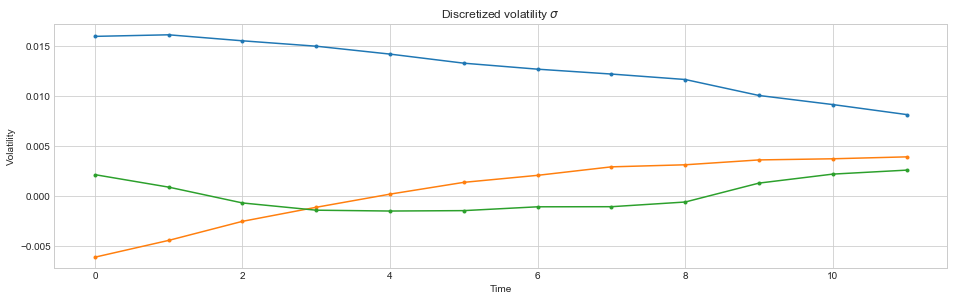

In [17]:
vol_compressed = np.sqrt(princ_eigvalues)*W_matrix 
plt.plot(vol_compressed, marker = '.'), plt.xlabel("Time"), plt.ylabel('Volatility')
plt.title("Discretized volatility $\sigma$")
plt.show()

**Volatility fitting** <br>

In [18]:
def interp_volatility(vols, tenors):
    """
    Parameters
    -------
    vols: volatility matrix to be interpolated (nObs x nFactors)
    tenors: array of tenors used for fitting
    Returns
    -------
    x: Volatility fitted polynomials
    save_pmts: poly weigths
    """
    x = np.zeros((vols.shape[0], vols.shape[1]))
    degree = 2
    save_pmts = []
    for i in range(0, vols.shape[1]):
        vol = np.array(vols[:,i].flatten())
        fit_vol = np.polyfit(x = tenors, y = vol, deg = degree)
        x[:,i] = np.polyval(fit_vol, tenors)
        degree = 4
        save_pmts.append(fit_vol)
    return x, save_pmts

In [19]:
fitted_vol, rg = interp_volatility(vol_compressed, tenors)

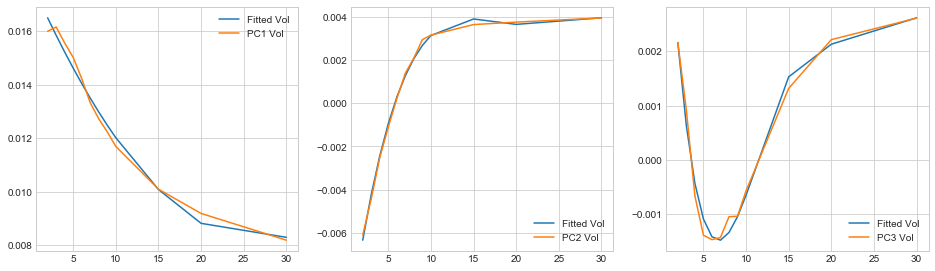

In [20]:
plt.subplot(1, 3, 1), plt.plot(tenors, fitted_vol[:,0]), plt.plot(tenors, vol_compressed[:, 0])
plt.legend(["Fitted Vol", "PC1 Vol"])
plt.subplot(1, 3, 2), plt.plot(tenors, fitted_vol[:,1]), plt.plot(tenors, vol_compressed[:, 1])
plt.legend(["Fitted Vol", "PC2 Vol"])
plt.subplot(1, 3, 3), plt.plot(tenors, fitted_vol[:,2]), plt.plot(tenors, vol_compressed[:, 2])
plt.legend(["Fitted Vol", "PC3 Vol"])
plt.show()

In [21]:
# prova integrale numerico
test = np.poly1d(rg[0]) # funzione del primo componente
prova = integrate.quad(test, a = 1, b = 10)[0]
prova

0.12977741560729616

### HJM framework (Brigo Mercurio p.232 pdf)
$$df(t, T) = \alpha dt + \sigma(t, T) dW (t) $$
$$ f(0,T) = f^M(0,T)$$

### Gaussian HJM
Under the risk neutral measure $\mathbb{Q}$ the instantaneous forward rate process is:
$$df(t, T) = \sigma_f(t, T)^\top \sigma_P(t, T)dt + \sigma_f (t, T)^\top dW (t) $$
that can be rewritten as (pg 495 pdf Andersen-Piterbarg):
$$df(t, T) = \sigma_f(t, T)^\top \int_t^T\sigma_f(t, u)du dt + \sigma_f (t, T)^\top dW (t) $$
with $\sigma_f$ being a d-dimensional vector. <br>
Then we have specified the entire forward rate structure
$$P(t,T) = exp\bigg\{ - \int_t^T f(t,s) ds \bigg\}
$$

#### Risk Neutral drift 
Now use the fitted polynomial to define $\sigma_f$, the drift $\alpha(t,\tau)$ is calculated using numerical integration over that function <br><br>
$$ \alpha(t,T) =  \sigma(t, T)\int_t^T\sigma(t, u)du =\sum_{i=1}^n \sigma_i(t,T) \int_t^T \sigma_i(t,u)du  $$

In [22]:
vol_functions = [np.poly1d(coeff) for coeff in rg]

# t = 0 
def mu(T, vol_functions):
    mean = 0
    for sigma in vol_functions:
        comp_mean = integrate.quad(sigma, 0, T)[0] * sigma(T)
        mean += comp_mean
    return mean

In [23]:
simulation_tenors = np.linspace(0,30,12)
simulation_drift = np.array([mu(T, vol_functions) for T in simulation_tenors])
simulation_vols = fitted_vol.T

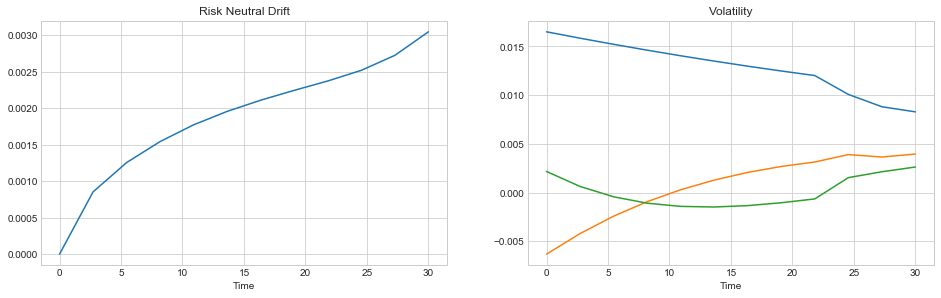

In [24]:
plt.subplot(1,2,1), plt.plot(simulation_tenors, simulation_drift), plt.xlabel("Time")
plt.title("Risk Neutral Drift")
plt.subplot(1,2,2), plt.plot(simulation_tenors, simulation_vols.T), plt.xlabel("Time")
plt.title("Volatility")
plt.show()

### Simulation (single path)
$$f(t, T) = f(0, T) + \sum_{i=1}^n \sigma_i(t,T) \int_t^T \sigma_i(t,u)du + \sum_{i=1}^n \sigma_i(t,T) dW (t) 
$$

In [25]:
spot_BTPcurve = data[-1::].values.flatten()
time_grid = np.linspace(0,5,500)
np.random.seed(12)

In [26]:
#@jit(nopython=True)
#def mc_path(f0, simulation_end, timesteps, simulation_tenors):
#    time_grid = np.linspace(0,simulation_end, timesteps)
#    f = np.zeros(len(simulation_tenors))
#    f_hjm = np.zeros((len(simulation_tenors), len(time_grid)))
#    f_hjm[:,0] = f0
#    lenvols = len(simulation_vols)
#    for i in range(1, len(time_grid)):
#        t = time_grid[i]
#        dt = t - time_grid[i-1]
#        # per ogni time step costruisce una curva intera di tassi forward
#        for T in range(len(simulation_tenors)):
#            # considerando 3 fattori di volatilità si dovranno anche considerare 3 BM non correlati
#            dW = np.random.normal(size = lenvols)
#            sigma = 0
#            for nVol, vol in enumerate(simulation_vols):
#                sigma += vol[T]*dW[nVol]
#            f[T] = f0[T] + simulation_drift[T] *dt + sigma*np.sqrt(dt)
#        f0 = f
#        f_hjm[:,i] = f
#    return f_hjm[0,:], f_hjm

In [32]:
#def fwd_alongMaturities(f0, simulation_tenors, simulation_vols, dt):
#    for T in range(len(simulation_tenors)):
#        # considerando 3 fattori di volatilità si dovranno anche considerare 3 BM non correlati
#        sigma = 0
#        for nVol, vol in enumerate(simulation_vols):
#            sigma += vol[T]*np.random.normal()
#        f[T] = f0[T] + simulation_drift[T] *dt + sigma*np.sqrt(dt)
#    return f

In [33]:
def mc_path(f0, simulation_end, timesteps, simulation_tenors):
    time_grid = np.linspace(0,simulation_end, timesteps)
    f = np.zeros(len(simulation_tenors))
    f_hjm = np.zeros((len(simulation_tenors), len(time_grid)))
    f_hjm[:,0] = f0
    lenvols = len(simulation_vols)
    for i in range(1, len(time_grid)):
        t = time_grid[i]
        dt = t - time_grid[i-1]
        # per ogni time step costruisce una curva intera di tassi forward
        for T in range(len(simulation_tenors)):
            # considerando 3 fattori di volatilità si dovranno anche considerare 3 BM non correlati
            sigma = 0
            for nVol, vol in enumerate(simulation_vols):
                sigma += vol[T]*np.random.normal()
            f[T] = f0[T] + simulation_drift[T] *dt + sigma*np.sqrt(dt)
        f0 = f
        f_hjm[:,i] = f
    return f_hjm[0,:], f_hjm

In [43]:
@jit(nopython=True)
def trapz_integral(f, t, T):
    assert T >= t
    summ = f.sum()
    N = len(f)
    integral = ((T-t)/N)*summ
    return integral

@jit(nopython=True)
def zcb_price(f, t, T):
    assert T >= t
    exponent = trapz_integral(f, t, T)
    PtT = np.exp(-exponent)
    return PtT

@jit(nopython=True)
def get_discount_curve(simulation_end, timesteps, fwd_rates, t, T):
    time_grid = np.linspace(0,simulation_end, timesteps)
    assert T >= t
    assert time_grid.shape == fwd_rates.shape
    
    for timestep, time in enumerate(time_grid):
        last_time = len(time_grid[time_grid <= T])
        forward_to_integrate = fwd_rates[:last_time]   
    return zcb_price(forward_to_integrate, t, T)


def mc_simulation(Nsimul, seed, f0, simulation_end, timesteps,simulation_tenors):
    np.random.seed(seed)
    fwd_simul = np.zeros((timesteps, Nsimul))
    zcb_curve = np.zeros((timesteps, Nsimul))
    for n in range(Nsimul):
        fwd_simul[:,n] = mc_path(f0, 5, timesteps, simulation_tenors)[0]
        zcb_curve[:,n] = np.array(
    [get_discount_curve(
        simulation_end, timesteps, fwd_simul[:,n], 0, taus)
     for taus in np.linspace(0,simulation_end, timesteps)])
    return fwd_simul, zcb_curve

In [44]:
seed = 123
fwd_simul, zcb_curve = mc_simulation(50, seed, spot_BTPcurve,5,500,simulation_tenors)

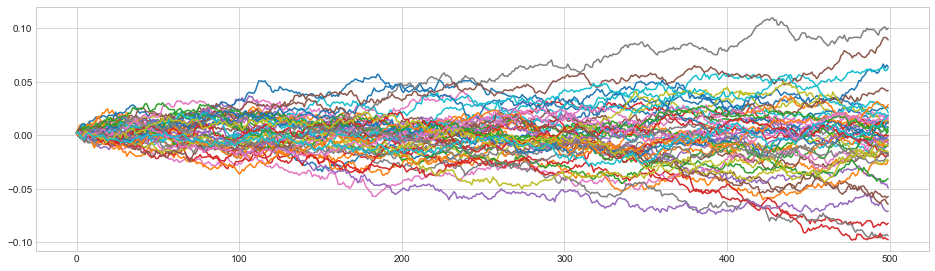

In [45]:
plt.plot(fwd_simul)
plt.show()

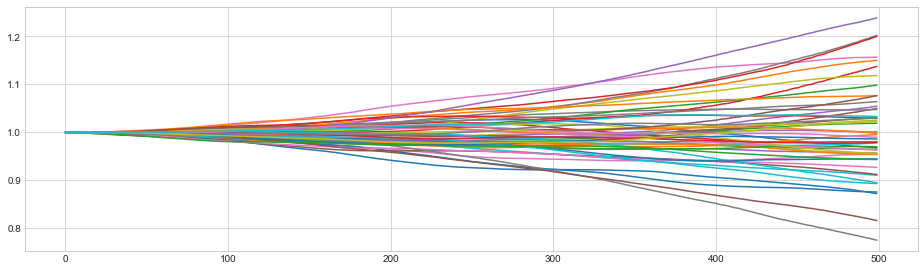

In [46]:
plt.plot(zcb_curve);

$$P(t,T) = exp\bigg\{ - \int_t^T f(t,s) ds \bigg\}
$$
Integrare $\int_t^T f(t,s) ds $ numericamente (trapezoidal rule)?
$$
\int_{t}^{T} f(t, s)ds \approx \frac{(T - t)}{Nsample}\sum_{i=1}^n f(t, T_i)
$$


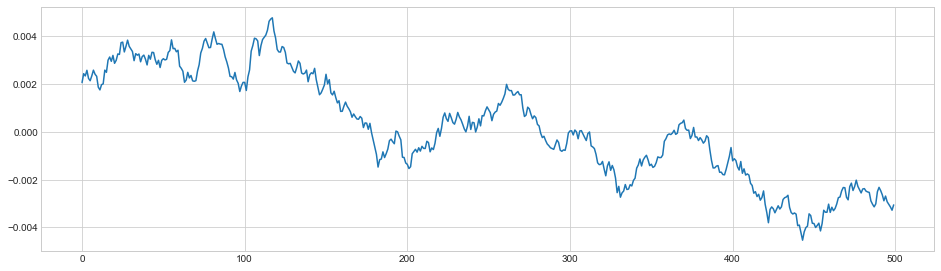

In [52]:
plt.plot(fwd_simul.mean(axis = 1))

In [ ]:
## zcb price test
#integra il forward istantaneo a t0 lungo tutto il time_grid 

In [ ]:
inst_forward_path = f_hjm[0,:]

In [ ]:
a = np.array(
    [get_discount_curve(time_grid, inst_forward_path, t, taus) for taus in np.linspace(0,5, 100)])

In [ ]:
a.shape

In [ ]:
plt.plot(a);